## Convolutional Neural Network (CNN)

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.metrics import mean_squared_error

In [4]:
# Load your data
raw_df = pickle.load(open("../common/pima.p", "rb"))
feature_cols_with_timestamp = pickle.load(open("../common/feature_cols_with_timestamp.p", "rb"))
split_size = pickle.load(open("../common/split_size.p", "rb"))

# Select the columns you're interested in
df = raw_df[feature_cols_with_timestamp]

C:\Users\dell\AppData\Local\Temp\ipykernel_28248\2435682925.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


14/14 [==============================] - 0s 3ms/step
Test RMSE: 2519.907


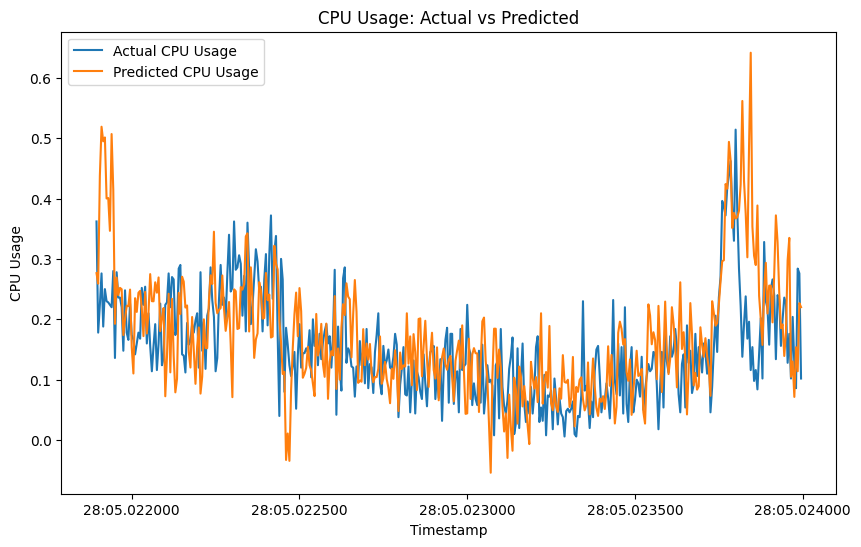

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Convert 'timestamp' to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Drop rows with missing values
df = df.dropna()

# Normalize your data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

# Convert the time series to supervised learning problem
n_steps = 60 
data = series_to_supervised(scaled, n_steps, 1)

# Split dataset
n_train_hours = int(len(data) * 0.8)
train = data[:n_train_hours]
test = data[n_train_hours:]

# Reshape data
x_train = train.iloc[:, :n_steps * 6].values
y_train = train.iloc[:, n_steps * 6:].values
x_test = test.iloc[:, :n_steps * 6].values
y_test = test.iloc[:, n_steps * 6:].values

# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], n_steps, 6))
x_test = x_test.reshape((x_test.shape[0], n_steps, 6))

# Define the CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 6)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(6))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(x_train, y_train, epochs=200, verbose=0)

# Make prediction
yhat = model.predict(x_test)

# Inverse scaling
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Plot the actual vs predicted values
time_index = df.index[len(df) - len(inv_y):]

plt.figure(figsize=(10, 6))

plt.plot(time_index, inv_y[:,0], label='Actual CPU Usage')
plt.plot(time_index, inv_yhat[:,0], label='Predicted CPU Usage')
plt.title('CPU Usage: Actual vs Predicted')
plt.ylabel('CPU Usage')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

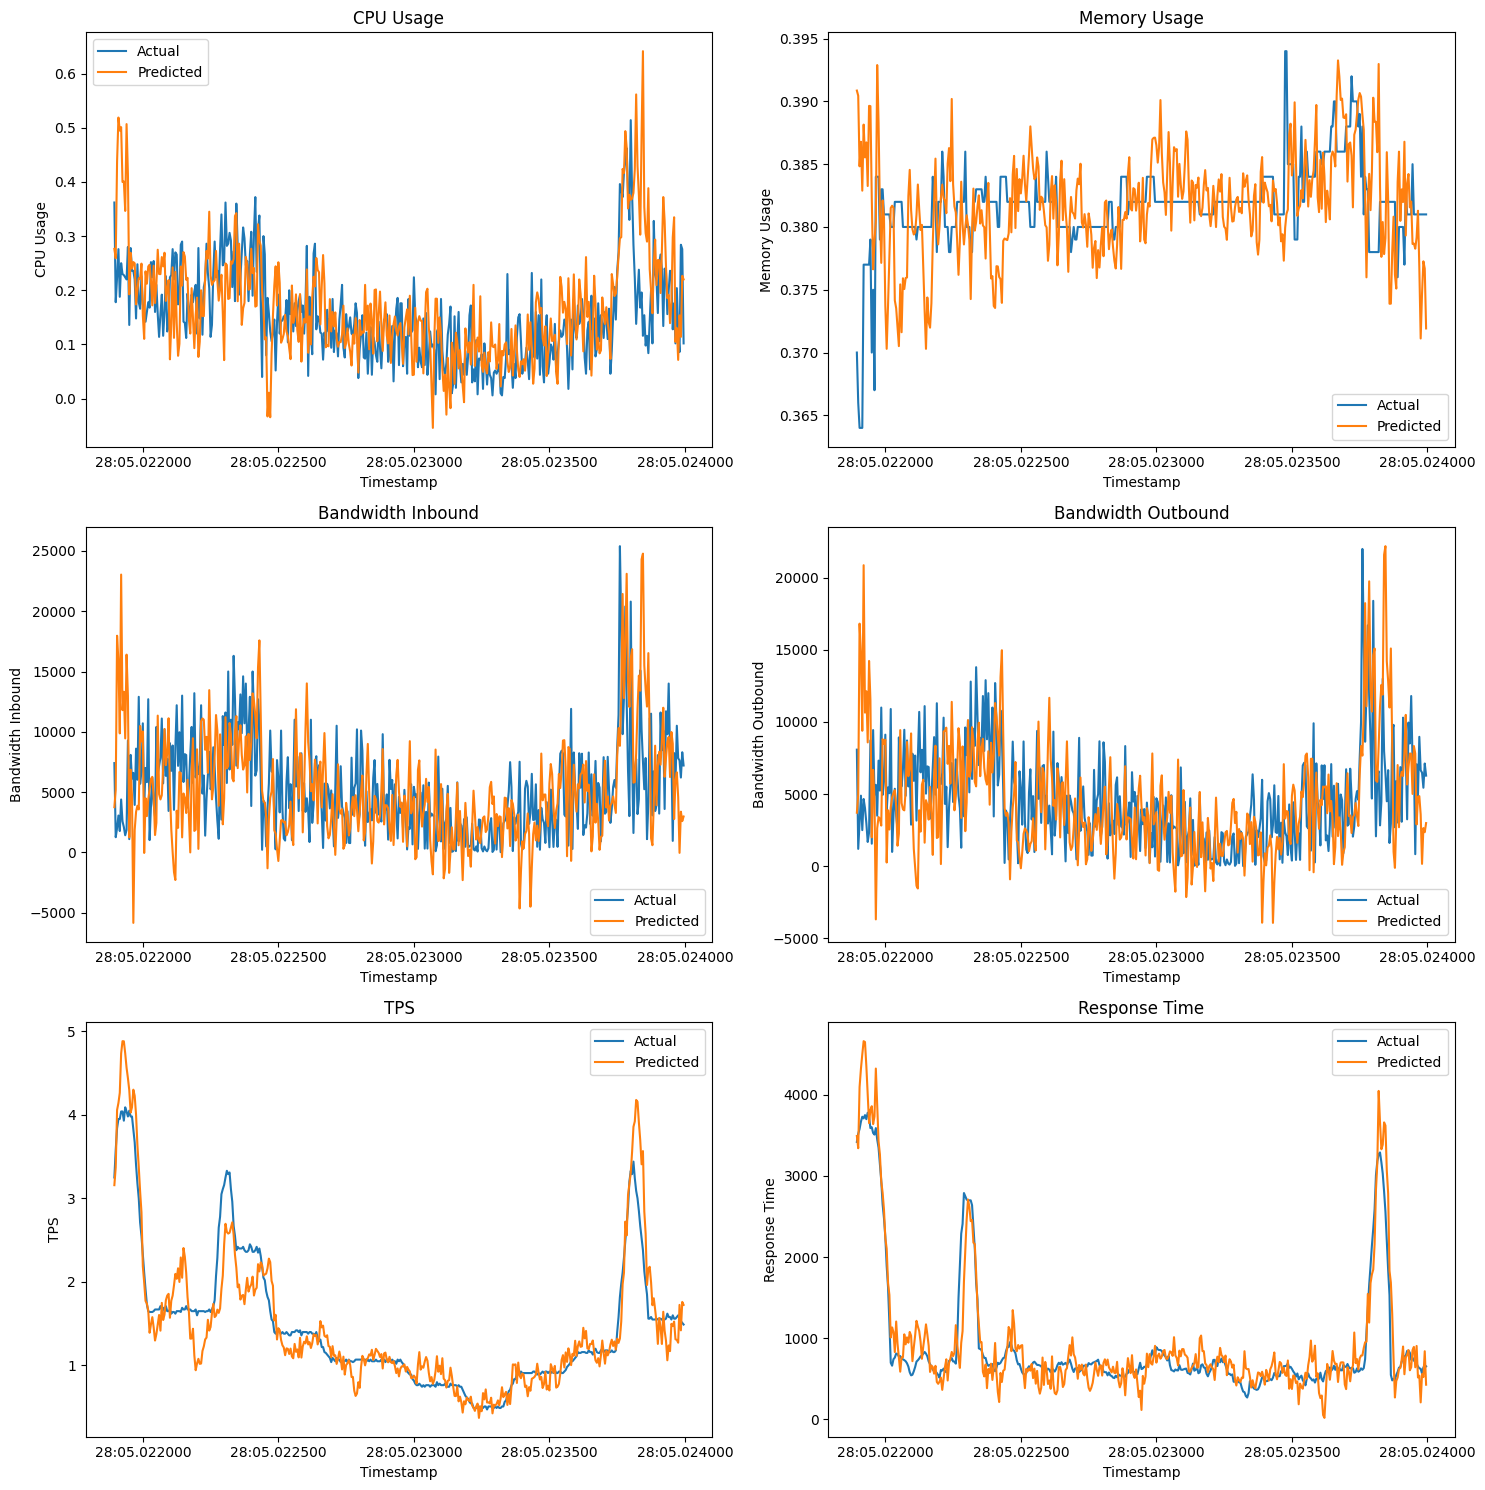

In [6]:
# Define metric names
metric_names = ["CPU Usage", "Memory Usage", "Bandwidth Inbound", "Bandwidth Outbound", "TPS", "Response Time"]

# Create subplots for each metric
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    ax.plot(time_index, inv_y[:,i], label='Actual')
    ax.plot(time_index, inv_yhat[:,i], label='Predicted')
    ax.set_title(metric_names[i])
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(metric_names[i])
    ax.legend()

# Adjust the layout
plt.tight_layout()
plt.show()